### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

### Loading the data

In [4]:
official_names = ['Pinene', 'Benzyl benzoate']
names = ['comp'+str(i) for i, el in enumerate(official_names)]

In [5]:
for i, sp in enumerate(names):
    confs = np.loadtxt('preprocessed_'+str(names[i])+'.csv', delimiter=',')
    globals()[sp] = NMRSpectrum(confs = list(zip(confs[:,0], confs[:,1])))

confs = np.loadtxt('preprocessed_mix.csv', delimiter=',')
mix = NMRSpectrum(confs = list(zip(confs[:,0], confs[:,1])))

In [6]:
spectra = [comp0, comp1]
spectra_and_mixture = [comp0, comp1, mix]

<IPython.core.display.Javascript object>


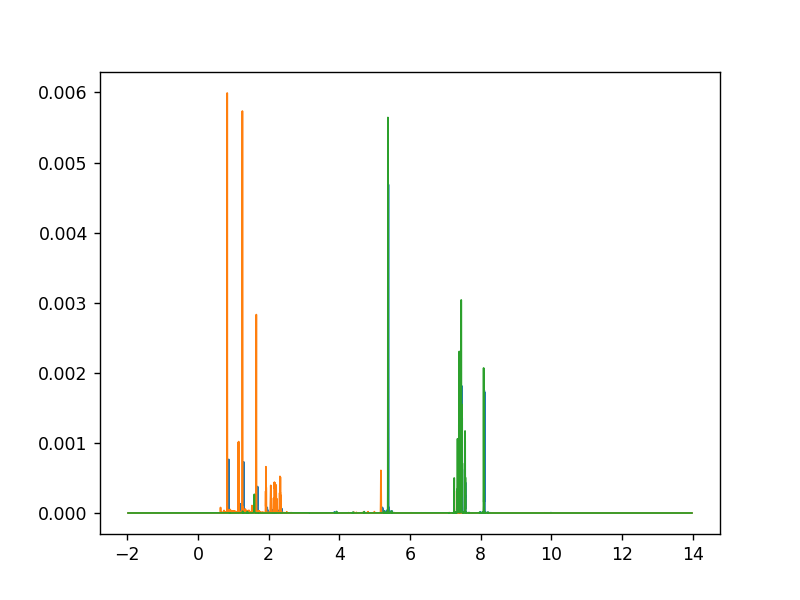

In [7]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Ground truth

In [8]:
protons = [16, 12]
mass_proportions = [0.0603, 0.9397]
molar_masses = [136.24, 212.25]

In [9]:
molar_proportions = [mass_prop/mol_mass for mass_prop, mol_mass in zip(mass_proportions, molar_masses)]
molar_proportions = [mol_prop/sum(molar_proportions) for mol_prop in molar_proportions]

In [10]:
molar_proportions

[0.09088457406472417, 0.9091154259352758]

In [11]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [12]:
real_visible_proportions

[0.11761626406540927, 0.8823837359345907]

In [13]:
mass_proportions

[0.0603, 0.9397]

In [14]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [15]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [19]:
# mix.plot(profile=True)
# comp0.plot(profile=True)
# comp1.plot(profile=True)

### Finding best values of the parameters

In [47]:
all_components_results_both[0.08][0.09]

0.011008543679603217

### Saving preprocessed spectra

In [ ]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')

### Estimation

#### Area

In [20]:
estimation = estimate_proportions(mix, [comp0, comp1],
                                   MTD=0.09, MTD_th=0.08, verbose=True, solver=pulp.GUROBI(msg=False), 
                                  what_to_compare='area')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 59.52it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41943.04it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.0616499999999998, 14.0618)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3208454.32it/s]


Ion currents in chunks: [1.0000000000000042]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.12s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9891180058439999
Noise proportion in experimental spectrum: 0.010881994155000015
Total explanation: 0.9999999999989999
Noise proportion in combination of theoretical spectra: 0.021767335575


In [21]:
estimation['proportion_of_noise_in_theoretical']

0.02176733557500009

In [22]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.11641497594500048, 0.8727030298990036]

In [23]:
real_visible_proportions

[0.11761626406540927, 0.8823837359345907]

In [24]:
old_prop = 0.021767335575000123
vortex_th_ok = np.isclose(estimation['proportion_of_noise_in_theoretical'], old_prop)
vortex_th_ok

True

In [25]:
old_estimation = [0.11641497594500065, 0.8727030298990048]
estimation_vis_ok = True
for new_est, old_est in list(zip(estimated_visible_proportions, old_estimation)):
    estimation_vis_ok = estimation_vis_ok and np.isclose(new_est, old_est)
estimation_vis_ok

True

#### Concentration

In [26]:
estimation = estimate_proportions(mix, [comp0, comp1],
                                   MTD=0.09, MTD_th=0.08, verbose=True, solver=pulp.GUROBI(msg=False), 
                                  what_to_compare='concentration')

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 64.07it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.0616499999999998, 14.0618)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3524685.77it/s]


Ion currents in chunks: [1.0000000000000042]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


Deconvolving chunks:   0%|                                | 0/1 [02:26<?, ?it/s]


TypeError: type NoneType doesn't define __round__ method

In [55]:
estimated_molar_proportions = estimation['proportions']
estimated_molar_proportions

[0.09094784882652851, 0.9090521511734716]

In [57]:
molar_proportions

[0.09088457406472417, 0.9091154259352758]

In [56]:
old_estimation_molar = [0.09094784882652851, 0.9090521511734715]
estimation_molar_ok = True
for new_est, old_est in list(zip(estimated_molar_proportions, old_estimation_molar)):
    estimation_molar_ok = estimation_molar_ok and np.isclose(new_est, old_est)
estimation_molar_ok

True

In [68]:
everything_ok = (vortex_th_ok and estimation_vis_ok) and estimation_molar_ok
if everything_ok:
    print('Everything ok with estimation.')
else:
    print('Problem with:')
    print([el for el in ['vortex_th_ok', 
                        'estimation_vis_ok', 
                        'estimation_molar_ok'] if not globals()[el]])

Everything ok with estimation.


### Visualisation of our estimation

In [59]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [60]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [61]:
p = estimated_visible_proportions

In [62]:
p = np.array(p).reshape(len(p),1)

In [63]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [64]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [65]:
X = np.concatenate(components_ints, axis=1)

In [66]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


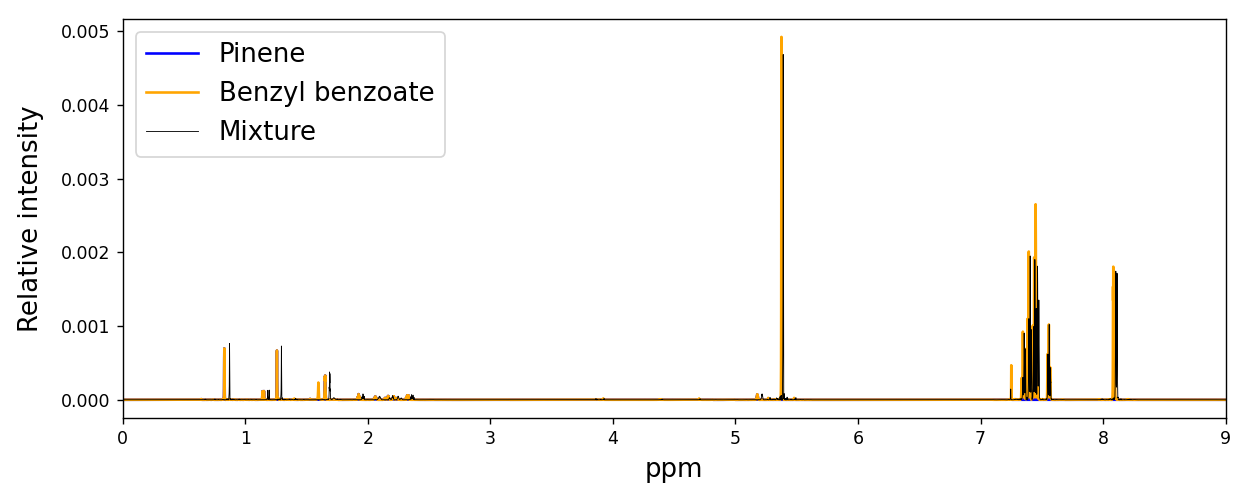

In [67]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
fig.set_size_inches(10, 4, forward=True)

ax.set_xlim(0,9)
# ax.set_ylim(-0.0001,0.0042)

plt.xlabel('ppm', fontsize=15, labelpad=5)
plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 15}, loc='upper left')
plt.tight_layout()